1. Imports and Setup

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random 
import numpy as np
import os
import src.custom_image3d as ci3d
from SitkDataSet import SitkDataset as SData
import SimpleITK as sitk
import src.rxfm_net as rxfm_net
from pytorch3d import transforms as pt3d_xfms
import time
import math 
from src import SphereInterp as SI

2. Load the Model Checkpoint

In [5]:
# Load the saved model checkpoint
checkpoint = torch.load('./saved_model/best_model_all_modality_multi_obj12.pth')
json_file_val = './test.json'
dataset_val = SData(json_file_val, "test")

3. Set the Device

In [6]:
# Set device (GPU or CPU)
dev = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading data on:", dev)

Loading data on: cuda


4. Create DataLoader

In [7]:
# Create a DataLoader
valloader = DataLoader(dataset_val, batch_size=1, shuffle=False)

5. Define Constants and Initialize Variables

In [8]:
IMG_SIZE = [96, 96, 96]
n_conv_chan = 1
n_chan = 64
overfit = True 
voxel_bound = 5 
epislon = 10e-3
trans_arr = np.zeros(len(valloader))
angular_arr = np.zeros(len(valloader))

# Create a directory to save results
directory_path = "./check_result"
if not os.path.exists(directory_path):
    os.mkdir(directory_path)

6. Load the Model and Set to Evaluation Mode

In [9]:
# Load the model
net_obj = rxfm_net.RXFM_Net_Wrapper(IMG_SIZE[0:3], n_chan, masks_as_input=False)
net_obj.load_state_dict(checkpoint['unimo_state_dict'])
net_obj = net_obj.to(dev)
net_obj.eval()

WARNING [spatial_mean]: pytorch reverses its axes because why not. Thus, pytorch(z,y,x) is the order output unless specified via:
 pytorch_order=False
 This order is NOT reversed (i.e. left ambiguous) in their affine_grid


/home/jianwang/Research/UNIMO/src/spatial_mean.py:30: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  coord_idx_tensor = torch.range(0,in_shape-1)


RXFM_Net_Wrapper(
  (rxfm_net_obj): RXFM_Net(
    (sequence): Sequential(
      (0): GatedBlock(
        (scalar_act): ScalarActivation()
        (gate_act): ScalarActivation()
        (conv): SE3Convolution (SE3Kernel ([(1, 0)] -> [(16, 0), (16, 1), (4, 2), (20, 0)], size=5), kwargs={'stride': 1, 'padding': 2, 'dilation': 1})
      )
      (1): GatedBlock(
        (scalar_act): ScalarActivation()
        (gate_act): ScalarActivation()
        (conv): SE3Convolution (SE3Kernel ([(16, 0), (16, 1), (4, 2)] -> [(16, 0), (16, 1), (4, 2), (20, 0)], size=5), kwargs={'stride': 1, 'padding': 2, 'dilation': 1})
      )
      (2): GatedBlock(
        (scalar_act): ScalarActivation()
        (gate_act): ScalarActivation()
        (conv): SE3Convolution (SE3Kernel ([(16, 0), (16, 1), (4, 2)] -> [(16, 0), (16, 1), (4, 2), (20, 0)], size=5), kwargs={'stride': 1, 'padding': 2, 'dilation': 1})
      )
      (3): GatedBlock(
        (scalar_act): ScalarActivation()
        (gate_act): ScalarActivation(

7. Testing Loop

In [10]:
# Testing
for idx, image_data in enumerate(valloader):
    source, tag = image_data

    # Correct the contrast for LungCT images with multiple objects
    if tag[0] == "Multi":
        source = 1 - source
    
    b = source.shape[0]    
    source = source.to(dev).float()   
    
    # Random rotation and translation
    rx_train = random.uniform(-math.pi, math.pi)
    ry_train = random.uniform(-math.pi, math.pi)
    rz_train = random.uniform(-math.pi, math.pi)

    tx_train = random.uniform(-voxel_bound, voxel_bound)
    ty_train = random.uniform(-voxel_bound, voxel_bound)
    tz_train = random.uniform(-voxel_bound, voxel_bound)
    
    # Create transformation matrix
    mat = ci3d.create_transform(
        rx=rx_train, ry=ry_train, rz=rz_train,
        tx=2.0*tx_train/IMG_SIZE[0], ty=2.0*ty_train/IMG_SIZE[1], tz=2.0*tz_train/IMG_SIZE[2]
    )
    
    mat = mat[np.newaxis, :, :]
    mat = mat[:, 0:3, :]
    mat = torch.tensor(mat).float()

    # Apply the transformation
    grids = torch.nn.functional.affine_grid(mat, [1, 1] + IMG_SIZE).to(dev)
    target = torch.nn.functional.grid_sample(source, grids, mode="bilinear", padding_mode='border', align_corners=True)

    # Convert to binary labels
    src_lb = (source >= epislon).to(dev).float()
    tar_lb = (target >= epislon).to(dev).float()
    
    # Save the source label
    saved = sitk.GetImageFromArray(np.array(src_lb[0, 0, :, :, :].detach().cpu()))
    save_name = f'./check_result/src_lbl_{idx}.nii.gz'
    sitk.WriteImage(saved, save_name)
    print(src_lb.shape)
    
    # Compute rigid transformation on both images and shapes
    xfm_1to2_I = net_obj.forward((source, target))
    xfm_1to2_G = net_obj.forward((src_lb, tar_lb))
    print(xfm_1to2_I.shape)
    
    # Fuse two rigid transformations
    Q_combined = SI.combine_rigid_transformations(xfm_1to2_I, xfm_1to2_G, 0.0)
    print(Q_combined.shape)
    
    # Apply combined transformation
    predicted_grids_a = torch.nn.functional.affine_grid(Q_combined, [1, 1] + IMG_SIZE)
    x_aligned = F.grid_sample(source, grid=predicted_grids_a, mode='bilinear', padding_mode='border', align_corners=True)
    x_aligned_lb = F.grid_sample(src_lb, grid=predicted_grids_a, mode='bilinear', padding_mode='border', align_corners=True)
    
    # Save the results
    for img, name in [(source, 'source'), (src_lb, 'src_lbl'), (target, 'target'), (tar_lb, 'tar_lbl'), (x_aligned, 'rigid')]:
        saved = sitk.GetImageFromArray(np.array(img[0, 0, :, :, :].detach().cpu()))
        save_name = f'./check_result/{name}_{idx}.nii.gz'
        sitk.WriteImage(saved, save_name)


/home/jianwang/miniconda3/envs/DNNVVR/lib/python3.10/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 1, 96, 96, 96])
torch.Size([1, 3, 4])
torch.Size([1, 3, 4])
torch.Size([1, 1, 96, 96, 96])
torch.Size([1, 3, 4])
torch.Size([1, 3, 4])
torch.Size([1, 1, 96, 96, 96])
torch.Size([1, 3, 4])
torch.Size([1, 3, 4])
torch.Size([1, 1, 96, 96, 96])
torch.Size([1, 3, 4])
torch.Size([1, 3, 4])
torch.Size([1, 1, 96, 96, 96])
torch.Size([1, 3, 4])
torch.Size([1, 3, 4])
torch.Size([1, 1, 96, 96, 96])
torch.Size([1, 3, 4])
torch.Size([1, 3, 4])


8. Visualization

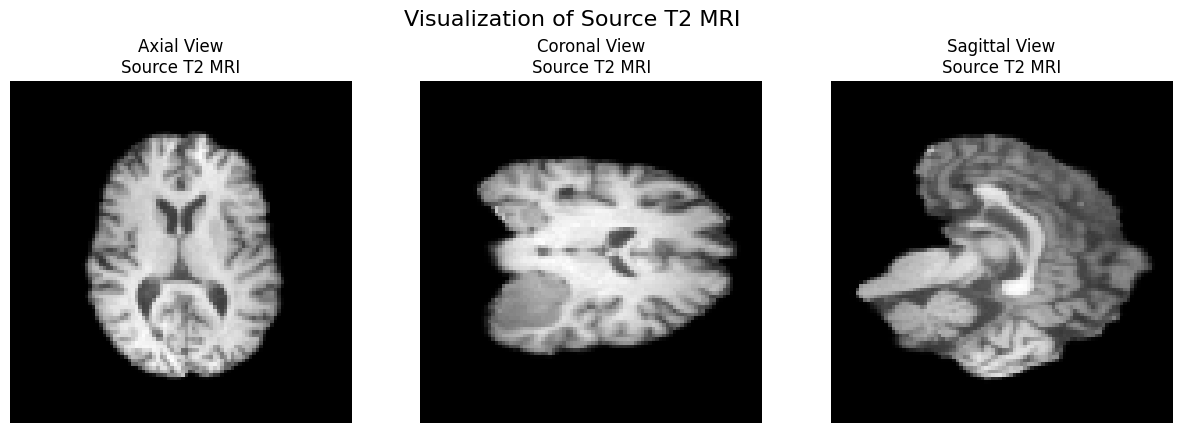

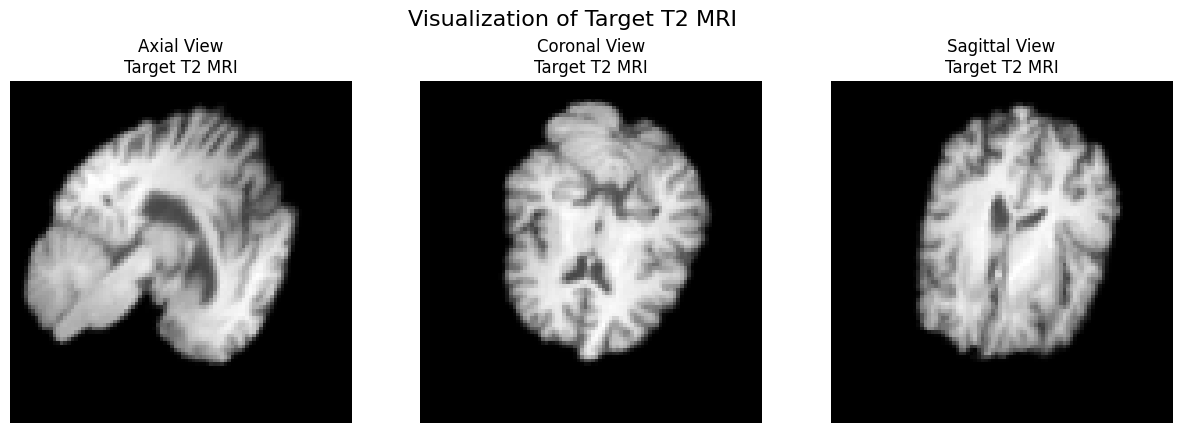

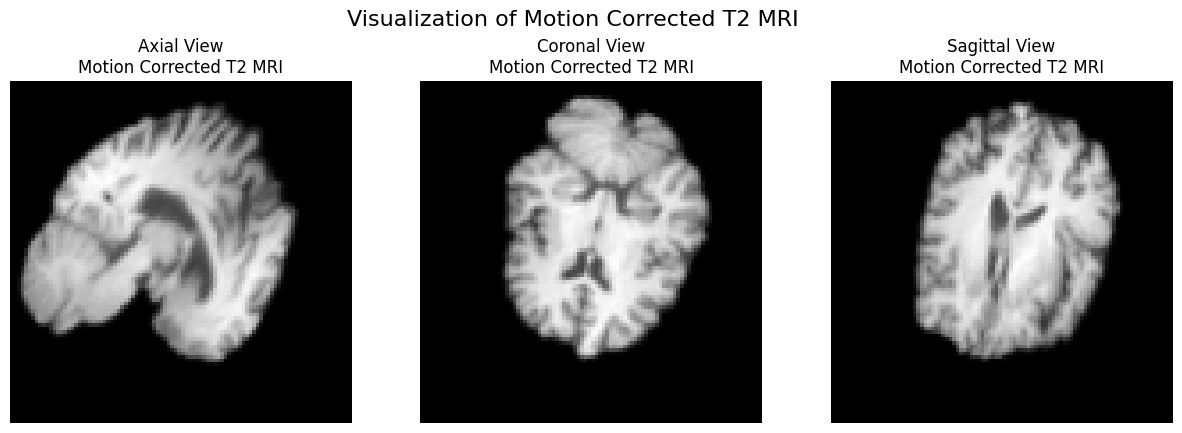

In [17]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Function to load and visualize all three orthogonal views from the saved NIfTI files with legends
def visualize_three_views_with_legend(file_path, label):
    # Load the NIfTI image
    img = sitk.ReadImage(file_path)
    
    # Convert the image to a NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Determine the center slices for each view
    axial_index = img_array.shape[0] // 2
    coronal_index = img_array.shape[1] // 2
    sagittal_index = img_array.shape[2] // 2
    
    # Extract slices for each view
    axial_slice = img_array[axial_index, :, :]
    coronal_slice = img_array[:, coronal_index, :]
    sagittal_slice = img_array[:, :, sagittal_index]
    
    # Plot the three views
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Axial view
    axes[0].imshow(axial_slice, cmap='gray')
    axes[0].set_title(f'Axial View\n{label}')
    axes[0].axis('off')
    
    # Coronal view
    axes[1].imshow(coronal_slice.T, cmap='gray')  # .T to transpose the view correctly
    axes[1].set_title(f'Coronal View\n{label}')
    axes[1].axis('off')
    
    # Sagittal view
    axes[2].imshow(sagittal_slice.T, cmap='gray')  # .T to transpose the view correctly
    axes[2].set_title(f'Sagittal View\n{label}')
    axes[2].axis('off')
    
    plt.suptitle(f'Visualization of {label}', fontsize=16)
    plt.show()

# File paths with labels
file_paths_with_labels = [
    ('./check_result/source_0.nii.gz', 'Source T2 MRI'),
    ('./check_result/target_0.nii.gz', 'Target T2 MRI'),
    ('./check_result/rigid_0.nii.gz', 'Motion Corrected T2 MRI')
]

# Visualize all three views for each saved file with legend
for file_path, label in file_paths_with_labels:
    visualize_three_views_with_legend(file_path, label)

 


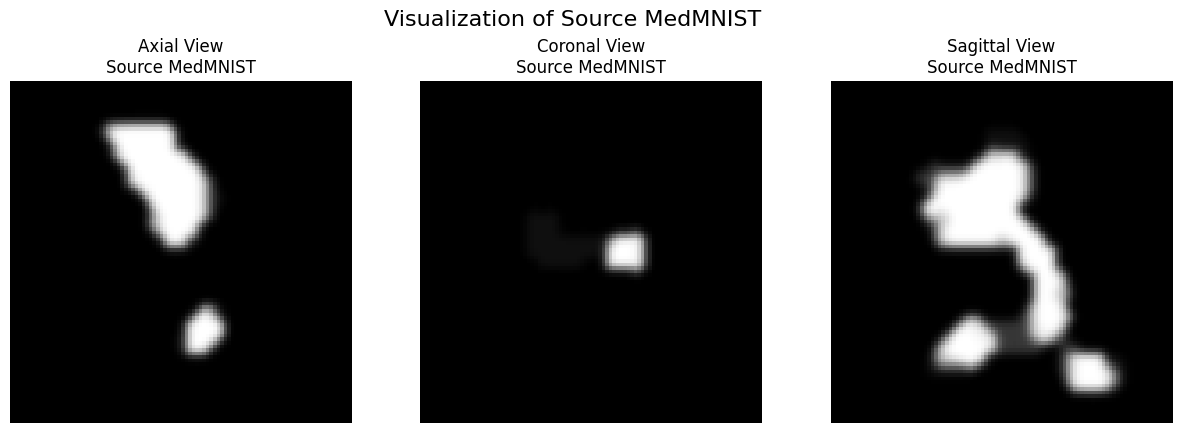

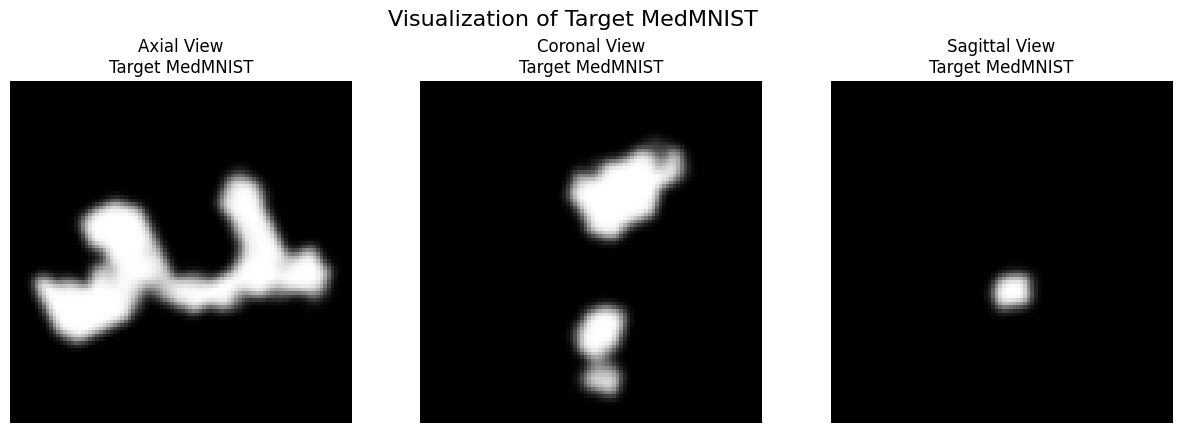

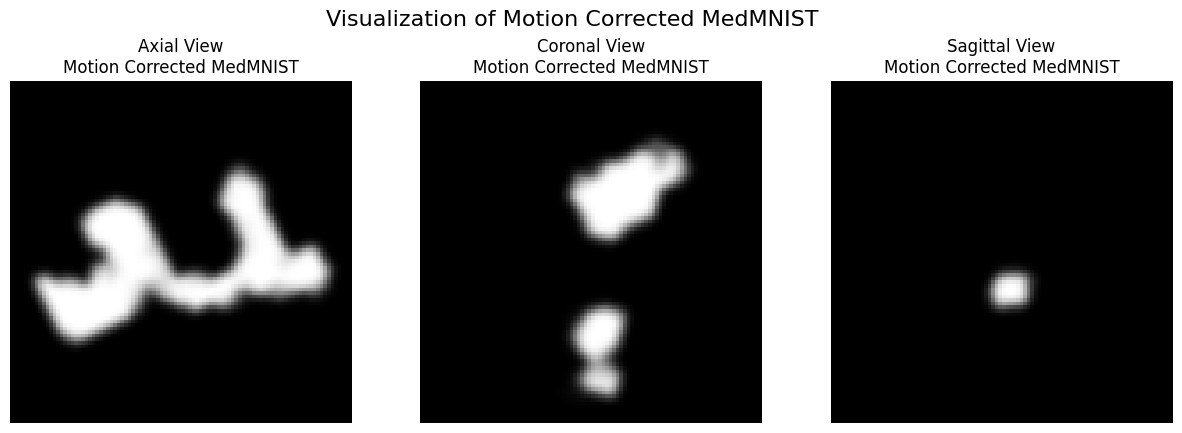

In [19]:
# File paths with labels
file_paths_with_labels = [
    ('./check_result/source_3.nii.gz', 'Source MedMNIST'),
    ('./check_result/target_3.nii.gz', 'Target MedMNIST'),
    ('./check_result/rigid_3.nii.gz', 'Motion Corrected MedMNIST')
]

# Visualize all three views for each saved file with legend
for file_path, label in file_paths_with_labels:
    visualize_three_views_with_legend(file_path, label)

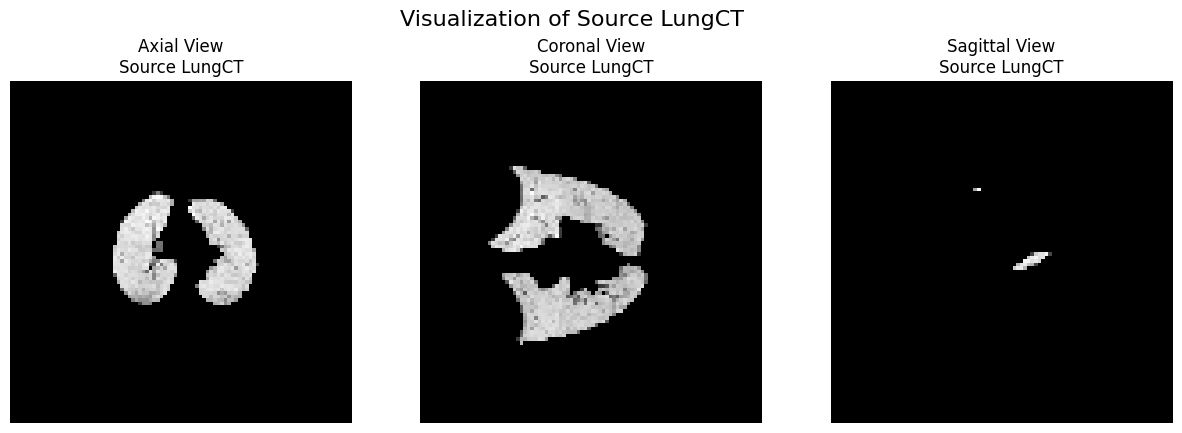

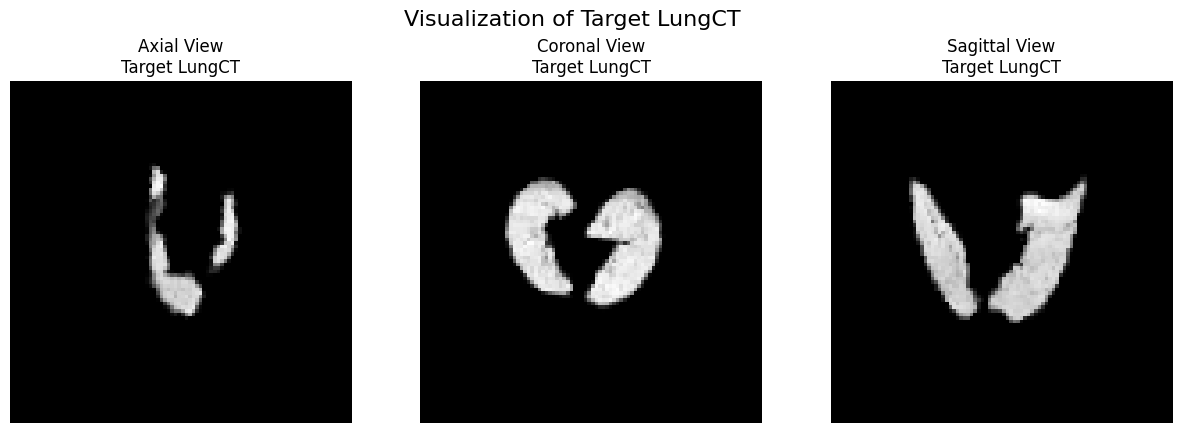

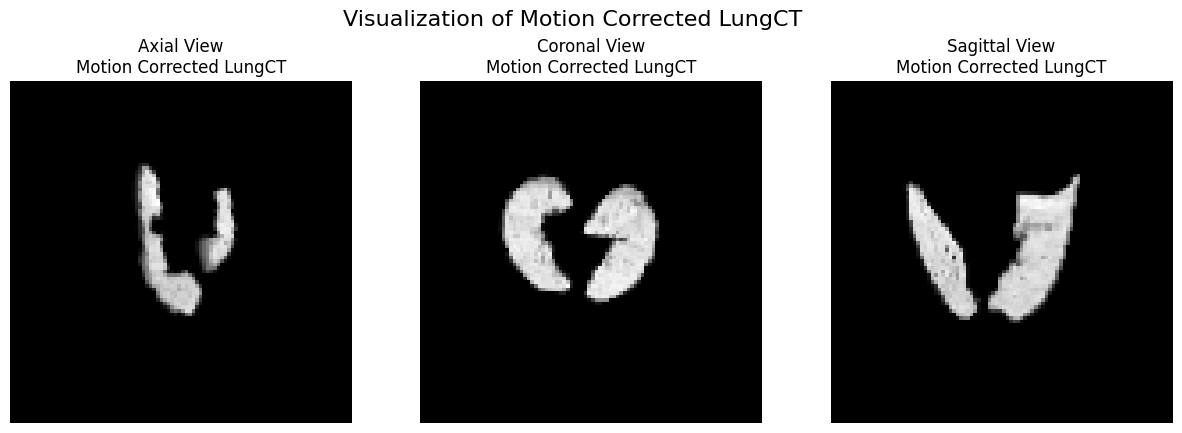

In [22]:
# File paths with labels
file_paths_with_labels = [
    ('./check_result/source_5.nii.gz', 'Source LungCT'),
    ('./check_result/target_5.nii.gz', 'Target LungCT'),
    ('./check_result/rigid_5.nii.gz', 'Motion Corrected LungCT')
]

# Visualize all three views for each saved file with legend
for file_path, label in file_paths_with_labels:
    visualize_three_views_with_legend(file_path, label)